In [3]:
pip install pandas numpy scikit-learn matplotlib yfinance tensorflow scikeras

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor

In [5]:
# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Calculate moving averages and relative price change
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['%_Price_Change'] = data['Close'].pct_change()

# set target as next days close
PREDICTED_DAYS = 5
for i in range(1, PREDICTED_DAYS + 1):
    data[f'Target_{i}'] = data['Close'].shift(-1 * i)

# Drop rows with missing values
data.dropna(inplace=True)

print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL   
Date                                                                           
2015-03-16  27.935471  31.237499  31.237499  30.717501  30.969999  143497200   
2015-03-17  28.402739  31.760000  31.830000  31.412500  31.475000  204092400   
2015-03-18  28.722454  32.117500  32.290001  31.592501  31.750000  261083600   
2015-03-19  28.505585  31.875000  32.312500  31.850000  32.187500  183238000   
2015-03-20  28.147867  31.475000  32.099998  31.290001  32.062500  274780400   

Price         SMA_10    SMA_50 %_Price_Change Target_1   Target_2   Target_3  \
Ticker                                                                         
Date                                                                           
2015-03-16  31.44475  29.91460       0.011004  31.7600  32.117500  31.875000   
2015-03-17  31.38675  30.00315       0.

In [6]:
#scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = data[['SMA_10', 'SMA_50', '%_Price_Change']]
X_scaled = scaler_X.fit_transform(X)

y = data[[f'Target_{i}' for i in range(1, PREDICTED_DAYS + 1)]]
y_scaled = scaler_y.fit_transform(y)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

#print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

In [7]:
#repeatable way to create the model 
def create_ann(neurons=32, activation='relu', optimizer='admin'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  #input structure
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(PREDICTED_DAYS)) #output
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

<h1> GridSearch setup </h1>

In [8]:
# defone model parameters and create model
param_grid = {
    'model__neurons': [16, 32, 64, 128],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [9]:
#training
model = KerasRegressor(model=create_ann, verbose=0) #keras regressor is a wrapper to us scikit learn gid search


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=100,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [10]:
# results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
# for i, row in results_df.iterrows():
#     print(f"Rank {row['rank_test_score']}:")
#     print(f"Parameters: {row['params']}")
#     print(f"Mean Test Score: {row['mean_test_score']:.4f}")
#     print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
#     print("-" * 30)

In [11]:
def graph_predictions(predictions, actual, title):
    # Visualize Predictions vs. Actual Outcomes
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predictions, alpha=0.7, color='b', label='Predicted vs Actual')
    plt.plot([predictions.min(), predictions.max()], [predictions.min(), predictions.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
    plt.title(f'{title}: Actual vs Predicted Values', fontsize=14)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(predictions, actual)
    mse = mean_squared_error(predictions, actual)
    rmse = np.sqrt(mse)

    print(f"{title}  MAE: {mae}")
    print(f"{title}  RMSE: {rmse}")

    # trueUp = 0 #predicted up actual up
    # trueDown = 0 #predicted down actual down
    # falseUp = 0 #prdicted up actual down
    # falseDown = 0 #predicted down actual up
    # for i in range(len(predictions)):
    #     if(predictions[i] <= 0 and actual[i] < 0):
    #         trueUp +=1
    #     elif(predictions[i] <= 0 and actual[i] > 0):
    #         falseUp +=1
    #     elif(actual[i] < 0):
    #         trueDown +=1
    #     else:
    #         falseDown +=1

    # confusion_matrix = np.array([[trueUp, falseDown], 
    #                          [falseUp, trueDown]])

    # # Labels for the axes
    # categories = ["Actual Up", "Actual Down"]
    # predictions = ["Predicted Up", "Predicted Down"]
    
    # # Plot the confusion matrix
    # plt.figure(figsize=(6, 6))
    # sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=predictions, yticklabels=categories)
    # plt.xlabel("Predicted Labels", fontsize=12)
    # plt.ylabel("Actual Labels", fontsize=12)
    # plt.title("Confusion Matrix", fontsize=14)
    # plt.show()
                
            
            









    

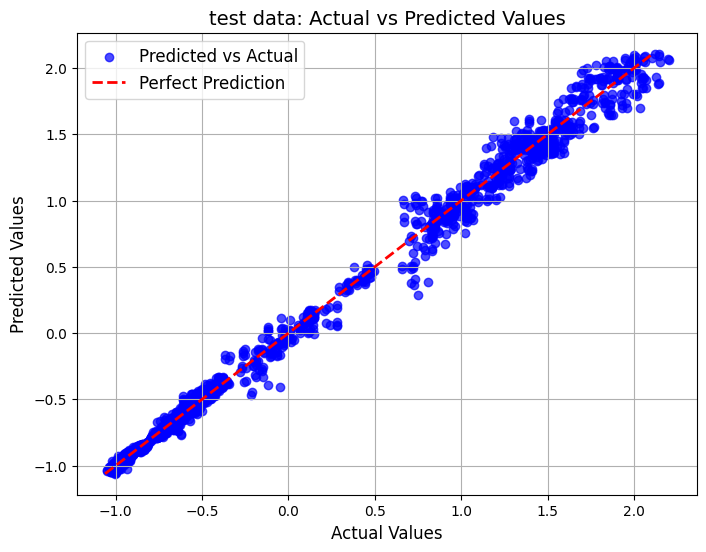

test data  MAE: 0.048638268466521806
test data  RMSE: 0.07610584869395179


In [12]:
# use best model to predict test data=
predictions = grid_search.best_estimator_.predict(X_test)
graph_predictions(predictions, y_test, "test data")


[*********************100%***********************]  1 of 1 completed


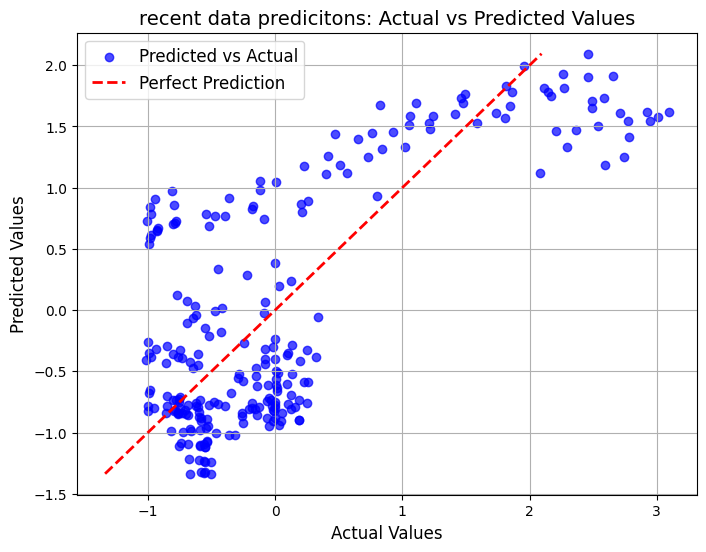

recent data predicitons  MAE: 0.6112841742693303
recent data predicitons  RMSE: 0.7405271934427319


In [15]:
# trying to predict more recent ones
stock = yf.Ticker('AAPL')
data_to_predict = yf.download("AAPL", start="2024-01-01", end="2024-06-01")
data_to_predict['SMA_10'] = data_to_predict['Close'].rolling(window=10).mean()
data_to_predict['SMA_50'] = data_to_predict['Close'].rolling(window=50).mean()
data_to_predict['Price_Change'] = data_to_predict['Close'].pct_change()
data_to_predict['Target'] = data_to_predict['Close'].shift(-1)
data_to_predict.dropna(inplace=True)

for i in range(1, PREDICTED_DAYS + 1):
    data_to_predict[f'Target_{i}'] = data_to_predict['Close'].shift(-1 * i)

#drop rows
data_to_predict.dropna(inplace=True)

X = data_to_predict[['SMA_10', 'SMA_50', 'Price_Change']]
Y = data_to_predict[[f'Target_{i}' for i in range(1, PREDICTED_DAYS + 1)]]

#preprocess
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)

predictions = grid_search.best_estimator_.predict(X_scaled)

mae = mean_absolute_error(Y_scaled, predictions)
mse = mean_squared_error(Y_scaled, predictions)
rmse = np.sqrt(mse)

graph_predictions(Y_scaled, predictions, "recent data predicitons")

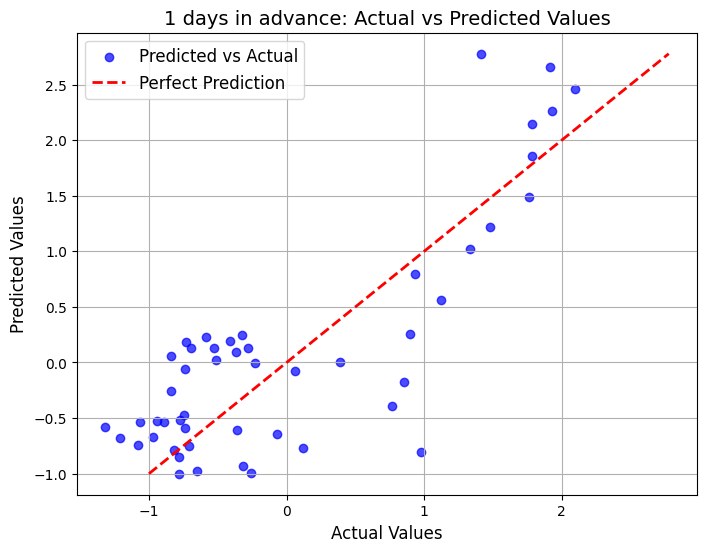

1 days in advance  MAE: 0.5156751756287822
1 days in advance  RMSE: 0.6204743219796578


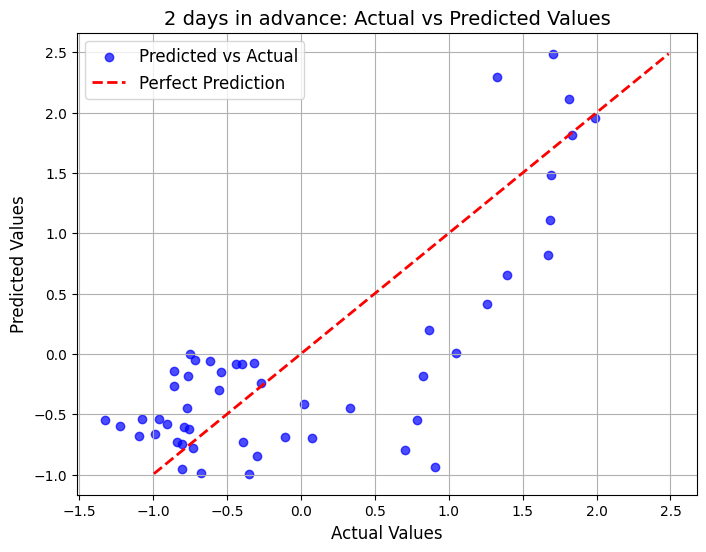

2 days in advance  MAE: 0.5401080160048098
2 days in advance  RMSE: 0.6587224419895877


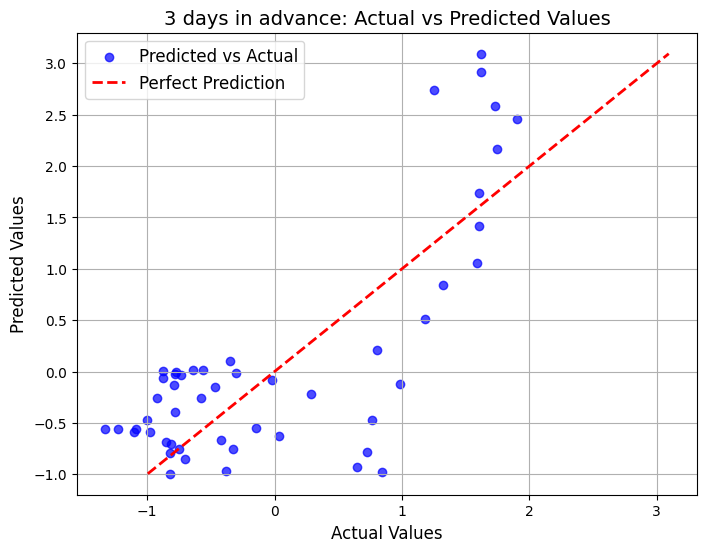

3 days in advance  MAE: 0.622124856502414
3 days in advance  RMSE: 0.7538975811990888


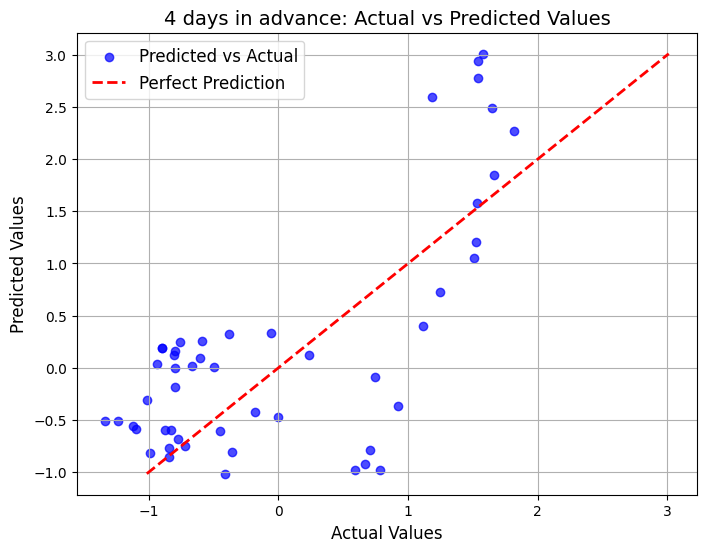

4 days in advance  MAE: 0.7021357407697053
4 days in advance  RMSE: 0.8396453835301035


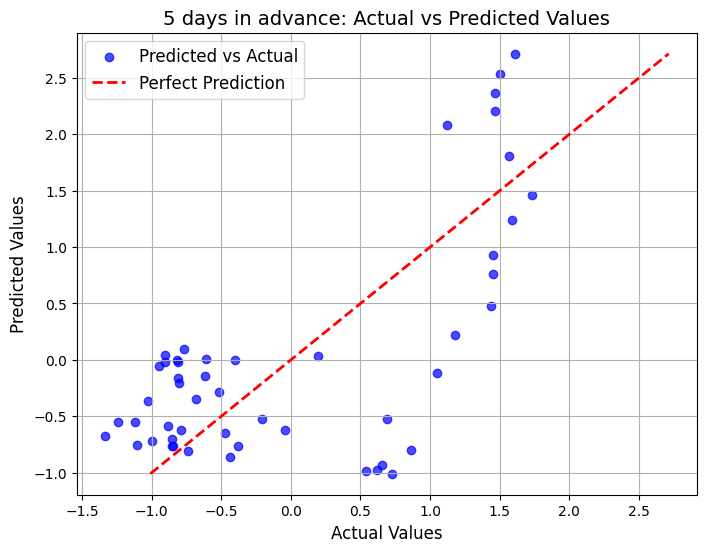

5 days in advance  MAE: 0.6763770824409407
5 days in advance  RMSE: 0.8059981689202235


In [16]:
for i in range(PREDICTED_DAYS):
    graph_predictions(predictions[:, i], Y_scaled[:, i], f'{i + 1} days in advance')
